In [1]:
import regex as re
import os

from collections import defaultdict

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

DATA_DIR = '../ustawy'

# Load data

Year is retrieved from "USTAWA z dnia...". Note that:
- USTAWA can be written as U S T A W A,
- it can can be followed by a word like "konstytucyjna" or a phrase like "budżetowa na rok ...".

In [2]:
dataset = defaultdict(list)

for file_name in os.listdir(DATA_DIR):
    if re.match(r'.*\.txt$', file_name):
        with open(f'{DATA_DIR}/{file_name}', 'r', encoding='UTF-8') as file:
            bill = file.read()
            year_regex = r'u\s*s\s*t\s*a\s*w\s*a\s+' + r'\w*\s*\w*\s*\w*\s*\d*\s*' + r'z\s+dnia\s+\d+\s+\w+\s+' + r'(\d{4})'
            year_match = re.search(year_regex, bill, re.IGNORECASE)
            if year_match is None:
                print(f'Cannot read {file_name}')
            else:
                year = int(year_match.group(1))
                dataset[year].append(bill)
            
dataset_years = sorted(dataset.keys())
pd.DataFrame([(year, len(dataset[year])) for year in dataset_years], columns=['year', 'bill count'])

Cannot read 1996_400.txt


,year,bill count
0,1993,10
1,1994,41
2,1995,62
3,1996,56
4,1997,100
5,1998,80
6,1999,109
7,2000,161
8,2001,198
9,2002,7


# Utils

In [3]:
def count_everywhere(p):
    matches = 0
    for year in dataset_years:
         for bill in dataset[year]:
            matches += len(p.findall(bill))
    
    return matches

def count_by_year(p):
    matches = defaultdict(int)
    for year in dataset_years:
        for bill in dataset[year]:
            matches[year] += len(p.findall(bill))
            
    return matches

# Task 1

Based on https://lexlege.pl/zasady-techniki-prawodawczej/.

At first let's prepare a regex for a unit. It includes unit groups (e.g. "ust. 2-5", "ust. 2 i 4").

General comment: to allow for line breaks and "unusual spaces", I use '\s+' instead of ' ' most often.

In [4]:
# unit_regex = r'(art\.|ust\.|pkt|lit\.|§)\s*\w+'
unit_regex = r'(art\.|ust\.|pkt|lit\.|§)\s*\w+(\s*i\s*\w+|\s*-\s*\w+)?'
unit_regex

'(art\\.|ust\\.|pkt|lit\\.|§)\\s*\\w+(\\s*i\\s*\\w+|\\s*-\\s*\\w+)?'

## 1.1. Addition

Now we can create the addition regex. It seems that "dodaje się" is the only phrase to add a unit.

In [5]:
addition_pattern = re.compile(r'dodaje\s+się\s+' + unit_regex, re.IGNORECASE)
addition_pattern

regex.Regex('dodaje\\s+się\\s+(art\\.|ust\\.|pkt|lit\\.|§)\\s*\\w+(\\s*i\\s*\\w+|\\s*-\\s*\\w+)?', flags=regex.I | regex.V0)

In [6]:
addition_dict = count_by_year(addition_pattern)
# addition_dict

## 1.2. Removal

Removal can be expressed as "skreśla się", but also as "uchyla się" (§ 85 technika prawodawcza). What's important, a unit can be either before or after the removal expression.

In [7]:
removal_pattern_1 = r'(skreśla|uchyla)\s+się\s+' + unit_regex
removal_pattern_2 = unit_regex + r'\s+(skreśla|uchyla)\s+się'

removal_pattern = re.compile(removal_pattern_1 + '|' + removal_pattern_2, re.IGNORECASE)
removal_pattern

regex.Regex('(skreśla|uchyla)\\s+się\\s+(art\\.|ust\\.|pkt|lit\\.|§)\\s*\\w+(\\s*i\\s*\\w+|\\s*-\\s*\\w+)?|(art\\.|ust\\.|pkt|lit\\.|§)\\s*\\w+(\\s*i\\s*\\w+|\\s*-\\s*\\w+)?\\s+(skreśla|uchyla)\\s+się', flags=regex.I | regex.V0)

In [8]:
removal_dict = count_by_year(removal_pattern)
# removal_dict

## 1.3 Change

Only "otrzymuje brzmienie" expression. Assumption: change of a single ("otrzymuje brzmienie") or multiple ("otrzymują brzmienie") units.

In [9]:
change_pattern = re.compile(unit_regex + r'\s+otrzymuj(e|ą)\s+brzmienie', re.IGNORECASE)
change_pattern

regex.Regex('(art\\.|ust\\.|pkt|lit\\.|§)\\s*\\w+(\\s*i\\s*\\w+|\\s*-\\s*\\w+)?\\s+otrzymuj(e|ą)\\s+brzmienie', flags=regex.I | regex.V0)

In [10]:
change_dict = count_by_year(change_pattern)
# change_dict

# Task 3

In [11]:
amendments_df = pd.DataFrame(zip(addition_dict.values(), removal_dict.values(), change_dict.values()), index=dataset_years, columns=['addition', 'removal', 'change'])
amendments_df

,addition,removal,change
1993,35,19,64
1994,86,40,83
1995,266,130,353
1996,280,238,490
1997,429,248,684
1998,493,387,954
1999,204,100,255
2000,929,574,1493
2001,1191,509,1562
2002,13,7,31


In [12]:
amendments_df_norm = amendments_df.div(amendments_df.sum(axis=1), axis=0) * 100
amendments_df_norm

,addition,removal,change
1993,29.661017,16.101695,54.237288
1994,41.148325,19.138756,39.712919
1995,35.514019,17.356475,47.129506
1996,27.777778,23.611111,48.611111
1997,31.520940,18.221896,50.257164
1998,26.881134,21.101418,52.017448
1999,36.493739,17.889088,45.617174
2000,31.008011,19.158879,49.833111
2001,36.511343,15.603924,47.884733
2002,25.490196,13.725490,60.784314


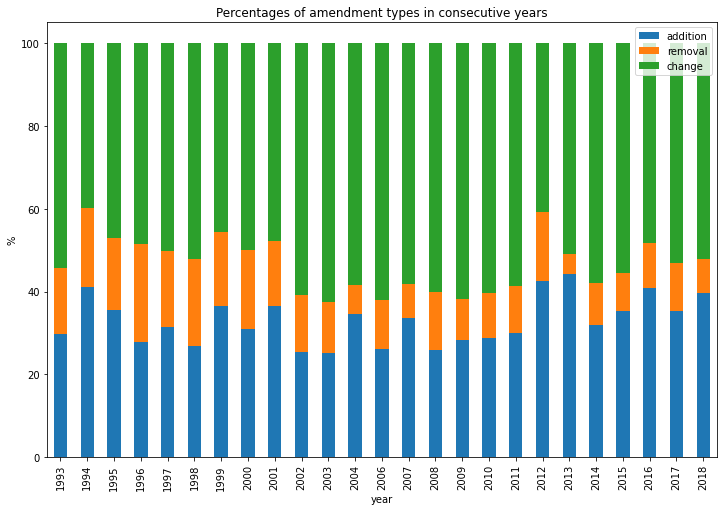

In [13]:
amendments_df_norm.plot(kind='bar', stacked=True, figsize=(12, 8), xlabel='year', ylabel='%', title='Percentages of amendment types in consecutive years')
None

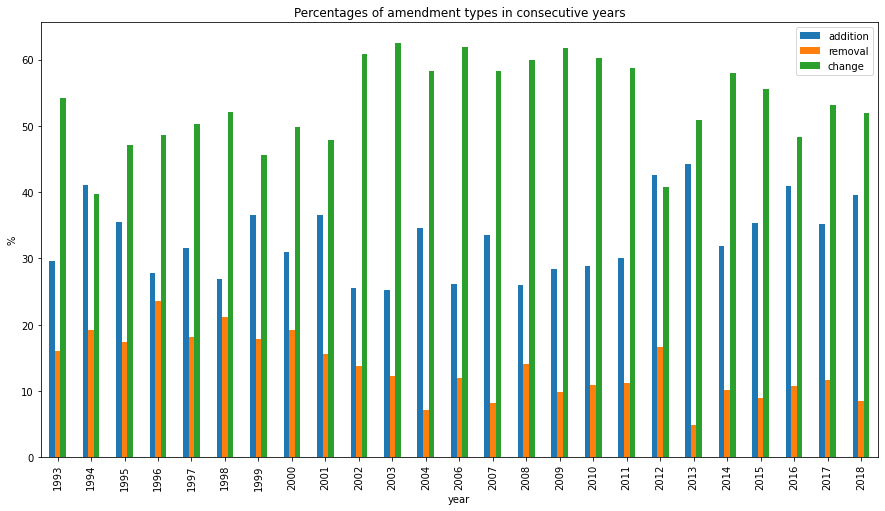

In [14]:
amendments_df_norm.plot(kind='bar', figsize=(15, 8), xlabel='year', ylabel='%', title='Percentages of amendment types in consecutive years')
None

# Task 4

Source of the inflectional forms: *Synteza morfologiczna* in http://morfeusz.sgjp.pl/demo/

In [15]:
bill_regex = r'\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\b'
bill_regex

'\\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\\b'

In [16]:
pattern_4 = re.compile(bill_regex, re.IGNORECASE)
pattern_4

regex.Regex('\\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\\b', flags=regex.I | regex.V0)

In [17]:
count_4 = count_everywhere(pattern_4)
count_4

24934

# Task 5

In [18]:
pattern_5 = re.compile(bill_regex + r'\s+z\s+dnia', re.IGNORECASE)
pattern_5

regex.Regex('\\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\\b\\s+z\\s+dnia', flags=regex.I | regex.V0)

In [19]:
count_5 = count_everywhere(pattern_5)
count_5

8588

# Task  6

In [20]:
pattern_6 = re.compile(bill_regex + r'(?!\s+z\s+dnia)', re.IGNORECASE)
pattern_6

regex.Regex('\\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\\b(?!\\s+z\\s+dnia)', flags=regex.I | regex.V0)

In [21]:
count_6 = count_everywhere(pattern_6)
count_6

16346

In [22]:
print('4.                         ustawa:', count_4)
print('5.    ustawa followed by "z dnia":', count_5)
print('6. ustawa not follwed by "z dnia":', count_6)
print('                 sum of 5. and 6.:', count_5 + count_6)

4.                         ustawa: 24934
5.    ustawa followed by "z dnia": 8588
6. ustawa not follwed by "z dnia": 16346
                 sum of 5. and 6.: 24934


The result is correct.

# Task 7

In [23]:
pattern_7 = re.compile(bill_regex + r'(?!\s+o\s+zmianie)', re.IGNORECASE)
pattern_7

regex.Regex('\\bustaw(a|y|ie|ę|ą|o|y|om|ami|ach)?\\b(?!\\s+o\\s+zmianie)', flags=regex.I | regex.V0)

In [24]:
count_7 = count_everywhere(pattern_7)
count_7

24900

In [25]:
count_4 - count_7

34

Almost all the occurences of "ustawa" are NOT followed by "o zmianie".

# Task 8

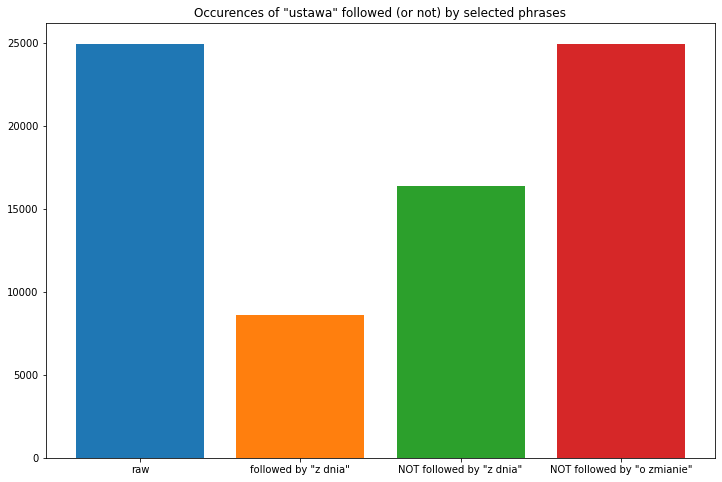

In [26]:
titles = ['ustawa', 'ustawa followed by "z dnia"', 'ustawa NOT followed by "z dnia"', 'ustawa NOT followed by "o zmianie"']
data = [count_4, count_5, count_6, count_7]

plt.figure(figsize=(12, 8))

plt.bar('raw', count_4)
plt.bar('followed by "z dnia"', count_5)
plt.bar('NOT followed by "z dnia"', count_6)
plt.bar('NOT followed by "o zmianie"', count_7)

plt.title('Occurences of "ustawa" followed (or not) by selected phrases')
plt.show()